In [40]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.optimizers import RMSprop, Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import keras.backend as K
import pickle
from tensorflow.keras.utils import to_categorical
from keras.layers import Input
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense,concatenate,add
)
from keras.optimizers import SGD
import glob
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
import seaborn as sns
from keras import Sequential
import math
import keras
from keras.preprocessing import image

## Loading Data

In [418]:
BASE_DIR = 'UTKFace/'

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
gender_dict = {0:'Male', 1:'Female'}

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img = img.resize((32, 32), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    
    return features

X = extract_features(df['image'])
X = X/255.0

y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
x_train = X[:14000]
y_gender_train = y_gender[:14000]
x_va = X[13000:]
y_gender_va = y_gender[13000:]

  0%|          | 0/23708 [00:00<?, ?it/s]

  0%|          | 0/23708 [00:00<?, ?it/s]

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_1641/3057271880.py:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((32, 32), Image.ANTIALIAS)


## Data Analysis

## Build Gender Network

In [256]:
def plot_loss_his(history):
    fig1 = plt.figure("Figure 1")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("")
    plt.legend()
    plt.grid(True)
    
def plot_acc_his(history):
    fig1 = plt.figure("Figure 2")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.title("")
    plt.legend()
    plt.grid(True)

In [419]:
# n = 64,128,256,512
def residual_module(inputs, n):
   # 1x1 conv with n filters
    identity_layer = Conv2D(n, (1,1), activation='relu')(inputs)
    
    conv_1 = Conv2D(n, kernel_size=(1, 1), activation='relu',padding='same') (inputs)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_2 = Conv2D(n, kernel_size=(3, 3), activation='relu',padding='same') (conv_1)
    conv_2 = layers.BatchNormalization()(conv_2)
    conv_3 = Conv2D(n, kernel_size=(1, 1), activation='relu',padding='same') (conv_2)
    conv_3 = layers.BatchNormalization()(conv_3)
  
    out = add([conv_2, identity_layer])
    out = Activation('relu')(out)
    return out

input_shape = (32, 32, 3)
inputs = Input((input_shape))

#pre-conv layer
pre_conv = Conv2D(64,(7,7),activation='relu',padding='same')(inputs)
pre_layer = MaxPooling2D(pool_size=(3, 3))(pre_conv)


# Level 1 of residual, 32 conv filters
L1 = residual_module(pre_layer, 32)

# # Level 2 of residual, 64 conv filters
L2 = residual_module(L1, 64)

# # Level 3 of residual, 128 conv filters
L3 = residual_module(L2, 128)

# # Level 4 of residual, 256 conv filters
L4 = residual_module(L3, 256)


# Outer level of residual block
L0_identity = Conv2D(256, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(pre_layer)
bottleneck = add([L4, L0_identity])
bottleneck = Activation('relu')(bottleneck)
bottleneck = layers.BatchNormalization()(bottleneck)


# max pooling
bottleneck = layers.MaxPooling2D(pool_size=(4, 4))(bottleneck)
flatten = Flatten() (bottleneck)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)


dropout_1 = Dropout(0.3) (dense_1)
dropout_1 = Dropout(0.5) (dropout_1)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)


gender_model = Model(inputs=inputs, outputs=output_1)

gender_model.compile(optimizer="adam", 
              loss={
                  'gender_out': 'binary_crossentropy'},
              metrics={       
                  'gender_out': 'accuracy'})
model.summary()

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_389 (Conv2D)            (None, 32, 32, 64)   9472        ['input_49[0][0]']               
                                                                                                  
 max_pooling2d_95 (MaxPooling2D  (None, 10, 10, 64)  0           ['conv2d_389[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_391 (Conv2D)            (None, 10, 10, 32)   2080        ['max_pooling2d_95[0][0]']

 activation_99 (Activation)     (None, 10, 10, 256)  0           ['add_99[0][0]']                 
                                                                                                  
 batch_normalization_277 (Batch  (None, 10, 10, 256)  1024       ['activation_99[0][0]']          
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_96 (MaxPooling2D  (None, 2, 2, 256)   0           ['batch_normalization_277[0][0]']
 )                                                                                                
                                                                                                  
 flatten_45 (Flatten)           (None, 1024)         0           ['max_pooling2d_96[0][0]']       
                                                                                                  
 dense_62 

In [420]:
# train model
history = gender_model.fit(x=x_train, y=y_gender_train, batch_size=64, epochs=35, validation_data=[x_va,y_gender_va])
gender_model.save("gender_model")

Epoch 1/35


2022-11-05 20:33:16.904296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.6791

2022-11-05 20:33:33.288871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 28s 87ms/step - loss: 0.7533 - accuracy: 0.6791 - val_loss: 0.6820 - val_accuracy: 0.5745
Epoch 2/35
219/219 [==============================] - 16s 72ms/step - loss: 0.4377 - accuracy: 0.7942 - val_loss: 0.5195 - val_accuracy: 0.7652
Epoch 3/35
219/219 [==============================] - 16s 72ms/step - loss: 0.3542 - accuracy: 0.8383 - val_loss: 0.3936 - val_accuracy: 0.8296
Epoch 4/35
219/219 [==============================] - 15s 68ms/step - loss: 0.3138 - accuracy: 0.8626 - val_loss: 0.4776 - val_accuracy: 0.8067
Epoch 5/35
219/219 [==============================] - 15s 67ms/step - loss: 0.2873 - accuracy: 0.8729 - val_loss: 0.3275 - val_accuracy: 0.8595
Epoch 6/35
219/219 [==============================] - 15s 70ms/step - loss: 0.2603 - accuracy: 0.8821 - val_loss: 0.3653 - val_accuracy: 0.8462
Epoch 7/35
219/219 [==============================] - 15s 70ms/step - loss: 0.2449 - accuracy: 0.8926 - val_loss: 0.3395 - val_accuracy: 0.8531
Epo

INFO:tensorflow:Assets written to: gender_model/assets


INFO:tensorflow:Assets written to: gender_model/assets


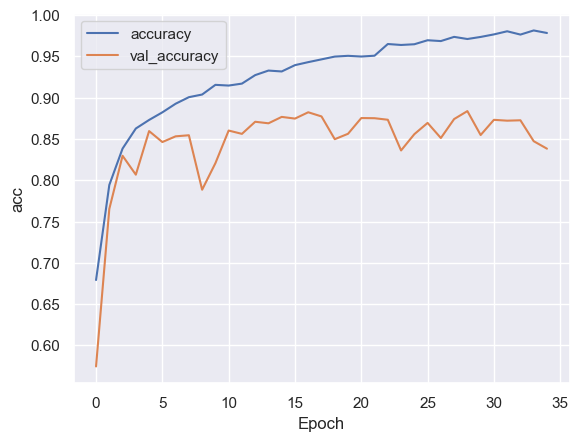

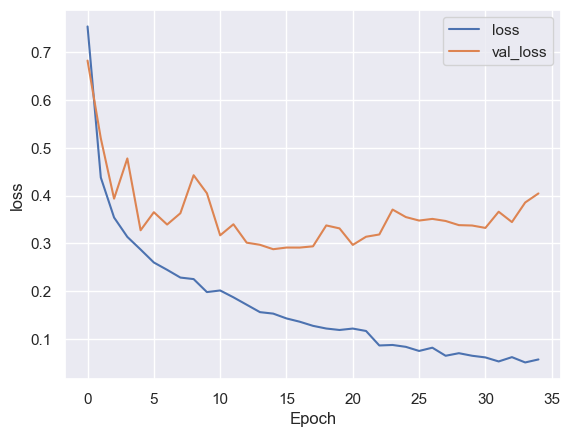

In [421]:
plot_acc_his(history)
plot_loss_his(history)

## Build Age network

In [293]:
BASE_DIR = 'UTKFace/'

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
gender_dict = {0:'Male', 1:'Female'}
df.sample(frac=1)

  0%|          | 0/23708 [00:00<?, ?it/s]

,image,age,gender
19292,UTKFace/30_1_0_20170117151337477.jpg.chip.jpg,30,1
11281,UTKFace/28_0_0_20170114030950715.jpg.chip.jpg,28,0
5676,UTKFace/54_0_0_20170120223421389.jpg.chip.jpg,54,0
6506,UTKFace/24_1_2_20170116170646374.jpg.chip.jpg,24,1
1505,UTKFace/26_1_3_20170117174259928.jpg.chip.jpg,26,1
...,...,...,...
6033,UTKFace/51_0_0_20170111181750495.jpg.chip.jpg,51,0
4648,UTKFace/36_0_0_20170117162925765.jpg.chip.jpg,36,0
9216,UTKFace/40_0_0_20170117135352413.jpg.chip.jpg,40,0
4047,UTKFace/22_1_3_20170117143734089.jpg.chip.jpg,22,1


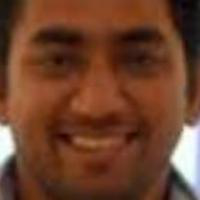

In [294]:
display(Image.open(df['image'][19]))

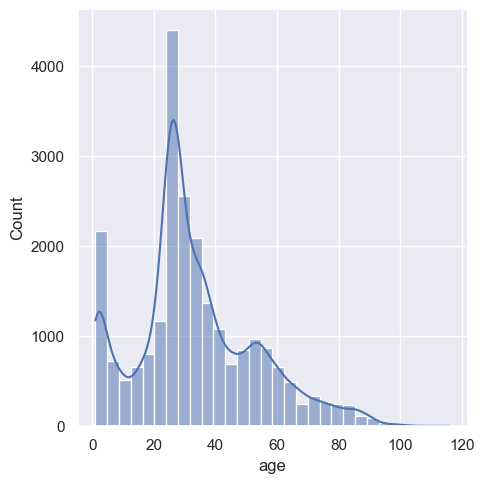

In [295]:
sns.set_theme()
sns.displot(df['age'],kde=True, bins=30)

In [296]:
age24_28 = []

for i in range(len(df)):
    if df['age'].iloc[i] >=24 and df['age'].iloc[i] <=28:
        age24_28.append(df.iloc[i])
age24_28 = pd.DataFrame(age24_28)
age24_28 = age24_28.sample(frac=0.3)

df1 = df[df['age'] <24]
df2 = df[df['age'] >28]
df = pd.concat([df1,df2, age24_28], ignore_index = True)

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_1641/1167467153.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'],kde=True, bins=30)


<AxesSubplot: xlabel='age', ylabel='Density'>

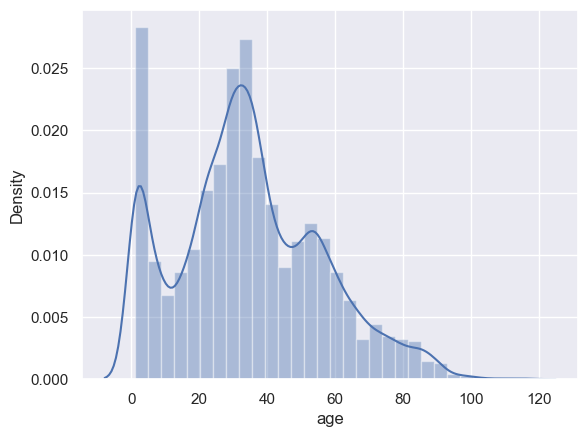

In [297]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [298]:
df = df[df['age']<=60]

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_1641/1167467153.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'],kde=True, bins=30)


<AxesSubplot: xlabel='age', ylabel='Density'>

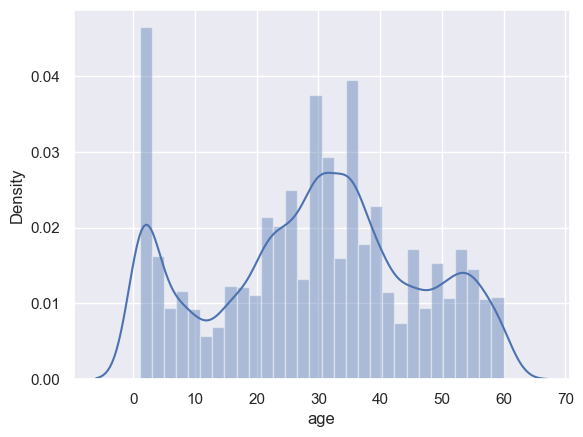

In [299]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [300]:
age_under4 = []
for i in range(len(df)):
    if df['age'].iloc[i] <=4:
        age_under4.append(df.iloc[i])
age_under4 = pd.DataFrame(age_under4)
age_under4 = age_under4.sample(frac=0.5)

df1 = df[df['age'] >4]
df = pd.concat([df1, age_under4], ignore_index = True)

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_1641/1167467153.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'],kde=True, bins=30)


<AxesSubplot: xlabel='age', ylabel='Density'>

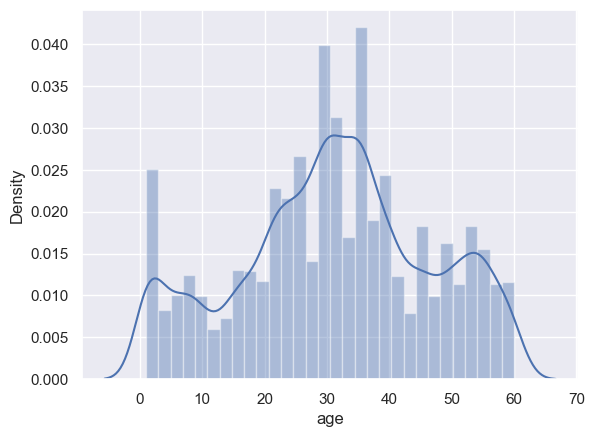

In [301]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [355]:
# train, validate data split
X = extract_features(df['image'])
X = X/255.0
y_age = np.array(df['age'])

age_off = 5
num_group = 60//age_off
age_group = []

for i in range(len(y_age)):
    group_num = int(math.ceil(y_age[i]/age_off))
    age_group.append(group_num)
    
y_age = np.array(age_group)
y_age = to_categorical(y_age)


  0%|          | 0/16502 [00:00<?, ?it/s]

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_1641/3057271880.py:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((32, 32), Image.ANTIALIAS)


<AxesSubplot: xlabel='gender', ylabel='age'>

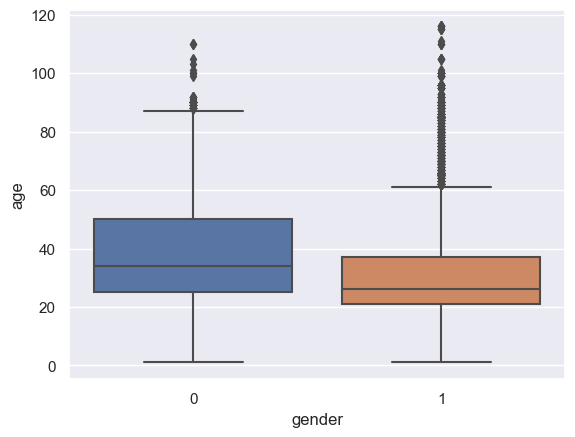

In [427]:
sns.boxplot(data=df, x='gender', y='age')

In [315]:
# split data based on gender, then do age group prediction


In [402]:
x_train = X[:14000]
y_age_train = y_age[:14000]
x_va = X[11000:14500]
y_age_va = y_age[11000:14500]

inputs = Input((32,32,3))
conv1 = keras.layers.Conv2D(filters = 16 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (inputs)
conv1 = layers.BatchNormalization()(conv1)
maxpool1 = keras.layers.MaxPool2D((2,2)) (conv1)

conv2 = keras.layers.Conv2D(filters = 32 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (maxpool1)
conv2 = layers.BatchNormalization()(conv2)
maxpool2 = keras.layers.MaxPool2D((2,2)) (conv2)


conv3 = keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (maxpool2)
conv3 = layers.BatchNormalization()(conv3)
maxpool3 = keras.layers.MaxPool2D((2,2)) (conv3)

# Flatten

flatten = keras.layers.Flatten()(maxpool3)

# Dense Layer

dense = keras.layers.Dense(128 , activation = 'relu') (flatten)

dense = layers.BatchNormalization()(dense)
drop = keras.layers.Dropout(0.4) (dense)

# Output 

output = keras.layers.Dense(num_group+1, activation = 'softmax' , name = 'gender_output') (drop)




age_model =  keras.models.Model(inputs=[inputs], outputs = [output])

age_model.compile(
    optimizer=  'adam',
    loss= 'categorical_crossentropy',
    metrics = 'accuracy'
)

In [403]:
history = age_model.fit(x= x_train , y = y_age_train, batch_size=64, epochs=50, validation_data=(x_va, y_age_va))
age_model.save("age_model")

Epoch 1/50


2022-11-05 19:32:24.227283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 2.6891 - accuracy: 0.1583

2022-11-05 19:32:30.897942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 8s 32ms/step - loss: 2.6891 - accuracy: 0.1583 - val_loss: 2.6260 - val_accuracy: 0.1363
Epoch 2/50
219/219 [==============================] - 5s 24ms/step - loss: 2.1693 - accuracy: 0.2309 - val_loss: 2.0777 - val_accuracy: 0.2131
Epoch 3/50
219/219 [==============================] - 5s 23ms/step - loss: 1.9728 - accuracy: 0.2768 - val_loss: 1.9045 - val_accuracy: 0.2546
Epoch 4/50
219/219 [==============================] - 5s 23ms/step - loss: 1.8526 - accuracy: 0.3093 - val_loss: 1.8218 - val_accuracy: 0.2669
Epoch 5/50
219/219 [==============================] - 5s 23ms/step - loss: 1.7583 - accuracy: 0.3366 - val_loss: 1.7184 - val_accuracy: 0.3297
Epoch 6/50
219/219 [==============================] - 5s 23ms/step - loss: 1.6901 - accuracy: 0.3634 - val_loss: 1.8940 - val_accuracy: 0.2591
Epoch 7/50
219/219 [==============================] - 5s 23ms/step - loss: 1.6250 - accuracy: 0.3847 - val_loss: 1.7191 - val_accuracy: 0.3377
Epoch 8/50

INFO:tensorflow:Assets written to: age_model/assets


INFO:tensorflow:Assets written to: age_model/assets


In [404]:
def plot_loss_his(history):
    fig1 = plt.figure("Figure 1")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("")
    plt.legend()
    plt.grid(True)
    
def plot_acc_his(history):
    fig1 = plt.figure("Figure 2")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.title("")
    plt.legend()
    plt.grid(True)

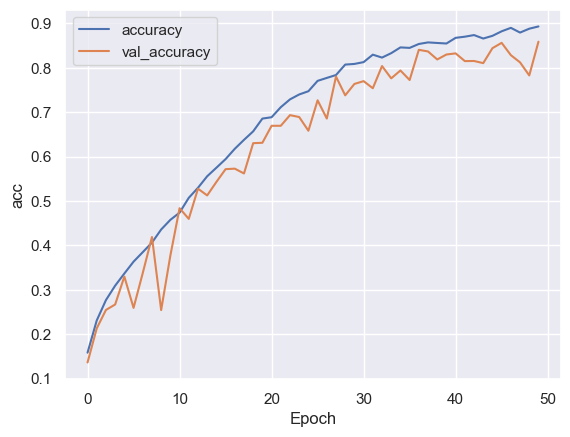

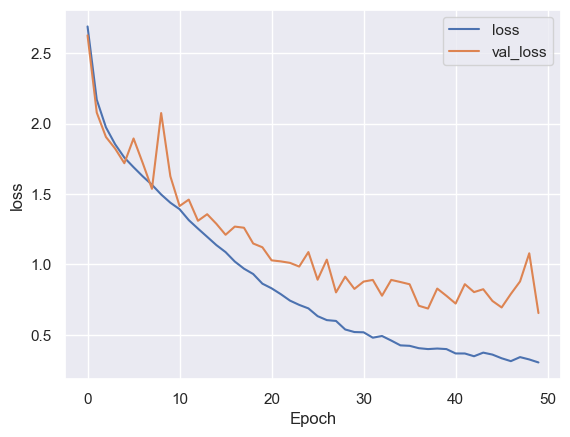

In [405]:
plot_acc_his(history)
plot_loss_his(history)

In [414]:
def pred_gender_age_group(idx):
    
    im = X[idx].reshape(1,32,32,3)
    # age group predict
    age_pred = age_model.predict(im)
    i = np.argmax(age_pred.flatten())
    low = age_off * (i-1)
    high = age_off * i
    
    # gender predict
    gender_pred = gender_model.predict(im)
    pred_gender = "male" if gender_pred.flatten()[0] <= 0.5 else "femal"
    true_gender = "male" if df["gender"][idx] ==0 else "femal"
    
    
    # print info 
    print("True gender: ", true_gender)
    print("Predict gender: ", pred_gender)
    print("True Age: ", df['age'][idx])
    print("Predict age group: %d - %d "%(low,high))
    img = Image.open(df['image'].iloc[idx])
    display(img)

1/1 [==============================] - 0s 13ms/step
True gender:  male
Predict gender:  male
True Age:  43
Predict age group: 40 - 45 


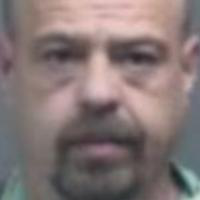

In [425]:
pred_gender_age_group(15000)